In [5]:
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

import cnn_builder as cbuild
import cnn_methods as cfunc
import config
import csv
import helper_fxns as hf
import importlib
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import pandas as pd
import random
%matplotlib inline

In [49]:
importlib.reload(config)
importlib.reload(cfunc)
importlib.reload(hf)
importlib.reload(cbuild)
C = config.Config()

In [ ]:
cbuild.overnight_run(C)

6cls accuracy: 0.8  - average: 0.8
3cls accuracy: 0.8625  - average: 0.8625
6cls accuracy: 0.8  - average: 0.8
3cls accuracy: 0.8625  - average: 0.8625
6cls accuracy: 0.7625  - average: 0.7875
3cls accuracy: 0.8375  - average: 0.854166666667
6cls accuracy: 0.8125  - average: 0.79375
3cls accuracy: 0.9  - average: 0.865625


In [47]:
def run_all():
    """Reruns everything except dimensions. Meant for overnight runs."""
    
    import dr_methods as drm
    import voi_methods as vm
    import artif_gen_methods as agm
    
    C = config.Config()
    drm.load_all_vois(C)
    
    intensity_df = drm.load_ints(C)
    intensity_df.to_csv(C.int_df_path, index=False)
    
    n = 1500
    for cls in C.classes_to_include:
        agm.gen_imgs(cls, C, n)
        if not os.path.exists(C.orig_dir + cls):
            os.makedirs(C.orig_dir + cls)
        if not os.path.exists(C.aug_dir + cls):
            os.makedirs(C.aug_dir + cls)
        if not os.path.exists(C.crops_dir + cls):
            os.makedirs(C.crops_dir + cls)
            
    final_size = C.dims

    voi_df_art = pd.read_csv(C.art_voi_path)
    voi_df_ven = pd.read_csv(C.ven_voi_path)
    voi_df_eq = pd.read_csv(C.eq_voi_path)
    intensity_df = pd.read_csv(C.int_df_path)
    
    small_vois = {}
    small_vois = vm.extract_vois(small_vois, C, voi_df_art, voi_df_ven, voi_df_eq, intensity_df)

    with open(C.small_voi_path, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in small_vois.items():
            writer.writerow([key, value])
            
    # scaled imgs
    t = time.time()
    for cls in C.classes_to_include:
        for fn in os.listdir(C.crops_dir + cls):
            img = np.load(C.crops_dir + cls + "\\" + fn)
            unaug_img = vm.resize_img(img, C.dims, small_vois[fn[:-4]])
            np.save(C.orig_dir + cls + "\\" + fn, unaug_img)
    print(time.time()-t)
    
    # augmented imgs
    t = time.time()
    for cls in C.classes_to_include:
        vm.parallel_augment(cls, small_vois, C)
        print(cls, time.time()-t)
        
    for cls in C.classes_to_include:
        vm.save_all_vois(cls, C)
        
    cbuild.overnight_run(C)

In [44]:
model = cbuild.build_cnn(C, 'adam')#Adam(lr=.005)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_69 (InputLayer)            (None, 36, 36, 12, 1) 0                                            
____________________________________________________________________________________________________
input_70 (InputLayer)            (None, 36, 36, 12, 1) 0                                            
____________________________________________________________________________________________________
input_71 (InputLayer)            (None, 36, 36, 12, 1) 0                                            
____________________________________________________________________________________________________
conv3d_86 (Conv3D)               (None, 32, 32, 10, 64 1792        input_69[0][0]                   
___________________________________________________________________________________________

model = cbuild.run_cnn(model, C)

In [26]:
nb_classes = len(C.classes_to_include)
voi_df = pd.read_csv(C.art_voi_path)
orig_data_dict, num_samples = cfunc.collect_unaug_data(C, voi_df)
print(num_samples)

avg_X2 = {}
for cls in C.classes_to_include:
    avg_X2[cls] = np.mean(orig_data_dict[cls][1], axis=0)

{'hcc': 84, 'cholangio': 56, 'fnh': 59, 'colorectal': 72, 'hemangioma': 56, 'cyst': 75}


In [27]:
train_ids = {} #filenames of training set originals
test_ids = {} #filenames of test set
X_test = []
X2_test = []
Y_test = []
Z_test = []
X_train_orig = []
X2_train_orig = []
Y_train_orig = []
Z_train_orig = []

train_samples = {}

for cls_num, cls in enumerate(orig_data_dict):
    cls_num = C.classes_to_include.index(cls)

    train_samples[cls] = round(num_samples[cls]*C.train_frac)

    order = np.random.permutation(list(range(num_samples[cls])))
    train_ids[cls] = list(orig_data_dict[cls][2][order[:train_samples[cls]]])
    test_ids[cls] = list(orig_data_dict[cls][2][order[train_samples[cls]:]])

    X_test = X_test + list(orig_data_dict[cls][0][order[train_samples[cls]:]])
    X2_test = X2_test + list(orig_data_dict[cls][1][order[train_samples[cls]:]])
    Y_test = Y_test + [[0] * cls_num + [1] + [0] * (nb_classes - cls_num - 1)] * \
                        (num_samples[cls] - train_samples[cls])
    Z_test = Z_test + test_ids[cls]

    X_train_orig = X_train_orig + list(orig_data_dict[cls][0][order[:train_samples[cls]]])
    X2_train_orig = X2_train_orig + list(orig_data_dict[cls][1][order[:train_samples[cls]]])
    Y_train_orig = Y_train_orig + [[0] * cls_num + [1] + [0] * (nb_classes - cls_num - 1)] * \
                        (train_samples[cls])
    Z_train_orig = Z_train_orig + train_ids[cls]

    print("%s has %d samples for training (%d after augmentation) and %d for testing" %
          (cls, train_samples[cls], train_samples[cls] * C.aug_factor, num_samples[cls] - train_samples[cls]))

#Y_test = np_utils.to_categorical(Y_test, nb_classes)
#Y_train_orig = np_utils.to_categorical(Y_train_orig, nb_classes)
X_test = [np.array(X_test), np.array(X2_test)]
X_train_orig = [np.array(X_train_orig), np.array(X2_train_orig)]

Y_test = np.array(Y_test)
Y_train_orig = np.array(Y_train_orig)

Z_test = np.array(Z_test)
Z_train_orig = np.array(Z_train_orig)

X_test = cfunc.separate_phases(X_test)
X_train_orig = cfunc.separate_phases(X_train_orig)

hcc has 67 samples for training (3350 after augmentation) and 17 for testing
cholangio has 45 samples for training (2250 after augmentation) and 11 for testing
fnh has 47 samples for training (2350 after augmentation) and 12 for testing
colorectal has 58 samples for training (2900 after augmentation) and 14 for testing
hemangioma has 45 samples for training (2250 after augmentation) and 11 for testing
cyst has 60 samples for training (3000 after augmentation) and 15 for testing


train_generator = train_generator_func()
model_pretrain.fit_generator(train_generator, steps_per_epoch=120, epochs=50)#, callbacks=[early_stopping])

In [33]:
#early_stopping = EarlyStopping(monitor='acc', min_delta=0.01, patience=4)
train_generator = cbuild.train_generator_func(C, train_ids, voi_df, avg_X2, n=5, n_art=3)
hist = model.fit_generator(train_generator, steps_per_epoch=1, epochs=3)#, callbacks=[early_stopping])

Epoch 1/3
1/1 [==============================] - 1s - loss: 1.5403 - acc: 0.4375
Epoch 2/3
1/1 [==============================] - 0s - loss: 1.1763 - acc: 0.5208
Epoch 3/3
1/1 [==============================] - 0s - loss: 1.1641 - acc: 0.6458


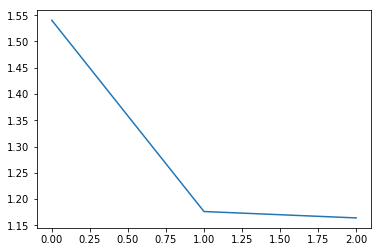

In [36]:
plt.plot(hist.history['loss'])

hist = model.fit(X_train2, Y_train2, batch_size=32, epochs=200, validation_data=(X_test, Y_test), callbacks=[early_stopping])

In [92]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)
voi_df_eq = pd.read_csv(C.eq_voi_path)

with open(C.small_voi_path, 'r') as csv_file:
    reader = csv.reader(csv_file)
    small_vois = dict(reader)
for key in small_vois:
    small_vois[key] = [int(x) for x in small_vois[key][1:-1].split(', ')]

In [ ]:
cbuild.overnight_run(C)

In [ ]:
C.output_img_dir = "Z:\\OUTPUT\\12-08-2d-bn"
C.classes_to_include

In [58]:
#plot_with_bbox(fn_list[2], cls_mapping[wrong_guesses[2]])
Y_pred = model.predict(X_test)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

#cfunc.save_output(Z_test, y_pred, y_true, voi_df_art, small_vois, C.classes_to_include, C)

In [ ]:
Y_pred = model.predict(X_train_orig)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_train_orig])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

#cfunc.save_output(Z_train_orig, y_pred, y_true, voi_df_art, small_vois, C.classes_to_include, C, save_dir="Z:\\OUTPUT\\12-08-3d\\training")

In [83]:
cm

array([[13,  0,  2, 41,  2, 11],
       [ 0,  0,  0, 24, 21,  0],
       [ 0,  0, 10, 47,  1,  0],
       [ 0,  0,  0, 58,  2,  0],
       [ 0,  0,  0, 37,  8,  0],
       [ 0,  0,  0, 11,  0, 36]], dtype=int64)

In [60]:
y_true_simp, y_pred_simp, _ = cfunc.condense_cm(y_true, y_pred, C.classes_to_include)

In [61]:
accuracy_score(y_true_simp, y_pred_simp)

0.86250000000000004

In [59]:
accuracy_score(y_true, y_pred)

0.78749999999999998

2d: 77%/84%, 74%/80%
3d: 78%/89%
2d bn: 77%/82%, 
3d bn: 84%/87%, 74%/83%
3d bn no artif: 84%/87%, 74%/83%
3d bn/elu/dilation/3conv/64-128-100-100: 80%/86%, 82%/88%, 84%/91%

fn_list = Z_test[~np.equal(y_pred, y_true)]
wrong_guesses = np.array(y_pred)[~np.equal(y_pred, y_true)]

activ = model2.predict(X_train)
#activ = model2.predict(np.expand_dims(X_train[10],axis=0))

import operator
#print("Ground truth:", [C.classes_to_include[max(enumerate(x), key=operator.itemgetter(1))[0]] for x in Y_val[::30]])
Y_ = model.predict(X_test)
print("Predictions:", [C.classes_to_include[max(enumerate(x), key=operator.itemgetter(1))[0]] + " (%.5f%% probability)" % (max(x)*100) for x in Y_])